![logo](../../../LogoLine_horizon_C3S.png)

# Satellite fire burned area trends assessment for climate monitoring  

Production date: 25/06/2024

Produced by: Rita Cunha (CoLAB +ATLANTIC)


## 🌍 Use case: Identification of fire risk trends in fire-prone areas

## ❓ Quality assessment question

* **How well can we disclose what are the trends and quality of the total burned area over the Iberian Peninsula?**

In this Use Case we will access the Fire burned area from 2001 to present derived from satellite observations (henceforth, FIRE) data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S) and analyse the spatial patterns of the FIRE reliability over a given Area of Interest (AoI), considering the Nomenclature of Territorial Units for Statistics, at the level 2, which are used for decision monitoring and decision-making purposes (see section 3).

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note
* The dataset shows strong spatial completeness by covering key NUTS 2 regions and temporal completeness over an 18-year period. However, this study focuses only on the summer; hence, significant fire events outside of this season are not accounted for.
 
* The spatial resolution is sufficient to detect temporal and regional variations. For example, the dataset accurately reflects the burned area values observed during significant fire events, such as the summer of 2003 in Portugal. The burned area recorded (more than 200 km² in Centro PT region) is consistent with the Portuguese national statistics and findings by [[2]](https://doi.org/10.4000/MEDITERRANEE.9958) and [[10]](https://doi.org/10.3390/cli12090143). 

* Furthermore, the trend analysis indicates the absence of significant trends across the studied areas. These results are consistent those described in the literature, by [[8]](https://doi.org/10.1038/s41598-019-50281-2), where the authors showed non-significant changes of the Burned Area in Portugal (June to October, from 1980 to 2017). 
 
* These results are also consistent across different product versions, since a good global agreement has been described between FireCCI51, MCD64A1 c6 and GFED4 (all based on MODIS information), particularly starting in 2003 when both MODIS Terra and Aqua data were available. ([[9]](https://climate.esa.int/en/projects/fire/key-documents/); page 45)

## 📋 Methodology

**[](satellite_satellite-fire-burned-area_trend-assessment_q02:code-section-1)** 

**[](satellite_satellite-fire-burned-area_trend-assessment_q02:code-section-2)**

* **[](satellite_satellite-fire-burned-area_trend-assessment_q02:code-section-2.1)**

* **[](satellite_satellite-fire-burned-area_trend-assessment_q02:code-section-2.2)**

**[](satellite_satellite-fire-burned-area_trend-assessment_q02:code-section-3)**

## 📈 Analysis and results

(satellite_satellite-fire-burned-area_trend-assessment_q02:code-section-1)=
### 1. Data overview, download and NUTS regions definition

#### Import all the libraries/packages

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import regionmask
import scipy.stats
import shapely
import xarray as xr
from c3s_eqc_automatic_quality_control import download, utils

plt.style.use("seaborn-v0_8-notebook")

#### Data overview

To search for data, visit the CDS website: http://cds.climate.copernicus.eu Here you can search for 'Satellite observations' data using the search bar. The data we need for this tutorial is the Fire burned area from 2001 to present derived from satellite observations. This data provides global (at grid scale) and continents (at pixel scale) information of total burned area (BA), following the Global Climate Observing System (GCOS) convention. The dataset is provided with a high spatial resolution, through the analysis of reflectance changes from medium resolution sensors (Terra MODIS, Sentinel-3 OLCI) supported by thermal information.

The BA is identified by the date of the first detection of the burned signal in the case of the pixel product, and by the total BA per grid cell in the case of the grid product. Information such as land cover class, confidence level or standard error are also provided.

The BA products can be on pixel scale and grid scale, based on resolution and coverage. At the grid scale, data is provided globally with a horizontal resolution of 0.25° latitude by 0.25° longitude, offering a coarser spatial resolution that is suitable for broad, global analyses. 

This grid product data is available every 15 days in version 5.0cds and monthly in versions 5.1.1cds and 1.1. 

Conversely, at the pixel scale, data is more detailed, covering continents with a finer horizontal resolution of 250m or 300m, and is aggregated on a monthly basis. This pixel product provides higher spatial resolution suitable for more localized, detailed studies.

Different versions are available, offering the first global BA time series at 250 m resolution (FireCCI v5.0cds and FireCCI v5.1cds developed as part of the Fire ECV Climate Change Initiative Project (Fire CCI)). This algorithm was adapted to Sentinel-3 OLCI data to create the C3S v1.1 burned area product, extending the BA database to the present.

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. In this Use case, we will retrieve information of the grid ESA-CCI version. These can all be selected in the `Download data` tab from the CDS. In this tab a form appears in which we will select the following parameters to download, for example:

- Origin: ESA-CCI
- Sensor: MODIS
- Variable: Grid
- Version: 5.1.1cds
- Region: all
- Year: 2001 to 2019
- Month: all
- Nominal day: 01
- Format: Zip file (.zip)

At the end of the download form, select `Show API request`. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook-

Having copied the API request to a Jupyter Notebook cell, running it will retrieve and download the data you requested into your local directory. However, before you run it, the terms and conditions of this particular dataset need to have been accepted directly at the CDS website. The option to view and accept these conditions is given at the end of the download form, just above the `Show API request` option. In addition, it is also useful to define the time period and AoI parameters and edit the request accordingly, as exemplified in the cells below.

In [2]:
# Time period
year_start = 2001
year_stop = 2019

# Region of interest
lon_slice = slice(-10, 4)
lat_slice = slice(45, 35)

# Shapefile with regions
shapefile_url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/shp/NUTS_RG_20M_2021_4326.shp.zip"

In [3]:
# Define request
request = (
    "satellite-fire-burned-area",
    {
        "format": "zip",
        "origin": "esa_cci",
        "sensor": "modis",
        "version": "5_1_1cds",
        "year": [str(year) for year in range(year_start, year_stop + 1)],
        "variable": "grid_variables",
        "month": ["06", "07", "08"],
        "nominal_day": "01",
    },
)

In [4]:
# Download and regionalize
ds = download.download_and_transform(
    *request,
    transform_func=utils.regionalise,
    transform_func_kwargs={"lon_slice": lon_slice, "lat_slice": lat_slice},
    chunks={"year": 1},
)

# Reindex using year/month (shift months + 1)
ds = ds.assign_coords(
    year=("time", ds["time"].dt.year.astype(int).values),
    month=("time", ds["time"].dt.month.astype(int).values + 1),
)
ds = ds.set_index(time=("year", "month")).unstack("time")

# Convert units from m2 to km2
da = ds["burned_area"]
with xr.set_options(keep_attrs=True):
    da *= 1.0e-6 # Conversion factor
da.attrs["units"] = "km2"

100%|██████████| 19/19 [00:02<00:00,  7.97it/s]


#### Define the unit of analysis: Nomenclature of territorial units for statistics, level 2 (NUTS 2)

The [NUTS](https://ec.europa.eu/eurostat/web/nuts) are a hierarchical system divided into 3 levels. NUTS 1 correspond to major socio-economic regions, NUTS 2 correspond to basic regions for the application of regional policies, and NUTS 3 correspond to small regions for specific diagnoses. Additionally, a NUTS 0 level, usually co-incident with national boundaries is also available. The NUTS legislation is periodically amended; therefore multiple years are available for download. 

In this user question, NUTS 2 will be used, providing the information regarding the main regions/parcels of the Iberian Peninsula.

Note: The sum of burned area and the climatology are calculated per each NUTS 2 region. Generated maps, bar charts and plots will take some minutes to process all the months, years and regions. 

In [19]:
# Merging BA with NUTS 2 geodataframe
lon_bounds = [-10.18, 1]
lat_bounds = [36.5, 43]
crs = "epsg:4326"

lon_bounds += sorted(lon_bounds, reverse=True)
lat_bounds = [lat for lat in lat_bounds for _ in range(2)]
bbox = shapely.Polygon(zip(lon_bounds, lat_bounds))

gdf = gpd.read_file(shapefile_url)
gdf = gdf[gdf["LEVL_CODE"] == 2]
gdf = gdf[gdf.intersects(bbox)]
gdf = gdf[gdf["NUTS_ID"].str.startswith(("ES", "PT"))]
gdf = gdf.to_crs(crs)

ds.rio.write_crs(crs, inplace=True)

regions = regionmask.from_geopandas(gdf, names="NUTS_NAME")
mask = regions.mask(ds["longitude"], ds["latitude"])

(satellite_satellite-fire-burned-area_trend-assessment_q02:code-section-2)=
### 2. Trend Analysis and Slope Calculation
#### Mann-Kendall Test and Theil-Senn slope

The Theil-Sen (1968) trend analysis, a non-parametric method, calculates the median slope of all data point pairs. It's a robust technique for trend identification, especially in the presence of outliers and noise. The Theil-Sen estimator offers several advantages, such as simplicity, resistance to extreme values, and statistical validity. This makes it a preferred choice for trend analysis in various applications 
The Sen slope estimator is found to be a powerful tool to develop the linear relationships. Sen’s slope has the advantage over the slope of regression, in the sense that gross data series errors and outliers do not have much effect. 

The Mann-Kendall test (Kendall, 1975; Mann, 1945) is a non-parametric test that determines whether there is a statistically significant upward or downward trend (monotonic trend) over time. Kendall's Tau (τ) is a measure of the strength and direction of monotonic trends in time series data. It is often used in environmental studies, hydrology, climatology, and various other fields to assess trends in data where the relationship may not be linear and where non-parametric methods are preferred and is often referred to as Kendall's Tau or Kendall's Rank Correlation Coefficient.

The τ value can be either positive or negative. It quantifies the strength and direction of the trend in the data.

* A positive tau (τ > 0) indicates an increasing or upward trend.
* A negative tau (τ < 0) indicates a decreasing or downward trend.
* A tau value close to zero (|τ| ≈ 0) suggests no significant trend or a random pattern in the data.

In addition to τ value, the Mann-Kendall test provides a p-value that indicates whether the observed trend is statistically significant. A low p-value (typically less than a chosen significance level, e.g., 0.05) suggests that the trend is statistically significant.

These methods were therefore adopted below to estimate trends and their statistical significance. 

(satellite_satellite-fire-burned-area_trend-assessment_q02:code-section-2.1)=
### 2.1. Annual Trend Analysis and Slope Calculation for specific hotspot regions

To illustrate the burned area trends, time series of the total burned area over four regions are shown (Galicia (ES), Andalucía (ES), Norte (PT) and Centro (PT)). For each time series, the Theil-Sen trend line is plotted and the values of its slope and intercept are provided, together with τ and the p-value, both returned by the Mann-Kendall test

In [20]:
#Computation and definition of Mean-Kendall and Theil-Sen Statistics 
da_grouped = da.groupby(mask.rename("region")).sum(("latitude", "longitude", "month"))
da_grouped = da_grouped.assign_coords(region=regions.names).compute()

df_dict = {"slope": [], "intercept": [], "tau": [], "p-value": []}
for region in gdf["NUTS_NAME"]:
    da_region = da_grouped.sel(region=region).squeeze()
    slope, intercept, *_ = scipy.stats.theilslopes(da_region, da_region["year"])
    tau, p_value = scipy.stats.kendalltau(da_region["year"], da_region)
    df_dict["slope"].append(slope)
    df_dict["intercept"].append(intercept)
    df_dict["tau"].append(tau)
    df_dict["p-value"].append(p_value)
gdf[list(df_dict)] = pd.DataFrame(df_dict, index=gdf.index)

In [21]:
#Function for ploting trends
def plot_trend(da, df, **kwargs):
    facet = da.plot(col="region", marker="o", sharex=False, **kwargs)
    for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
        if not sel_dict:
            continue
        da_sel = da.sel(sel_dict)
        df_region = df[df["NUTS_NAME"] == sel_dict["region"]].squeeze()
        ax.plot(
            da_sel["year"],
            da_sel["year"] * df_region["slope"] + df_region["intercept"],
            label="\n".join(
                [
                    f"slope = {df_region['slope']:.3f} km$^2$/year",
                    f"p-value = {df_region['p-value']:.3f}",
                    f"tau = {df_region['tau']:.3f}",
                    f"intercept = {df_region['intercept']:.3f} km$^2$",
                ]
            ),
            color="k",
            ls="--",
        )
        ax.set_xticks(da_sel["year"][::2])
        ax.set_title(sel_dict["region"])
        ax.legend()
        ax.grid()
    return facet

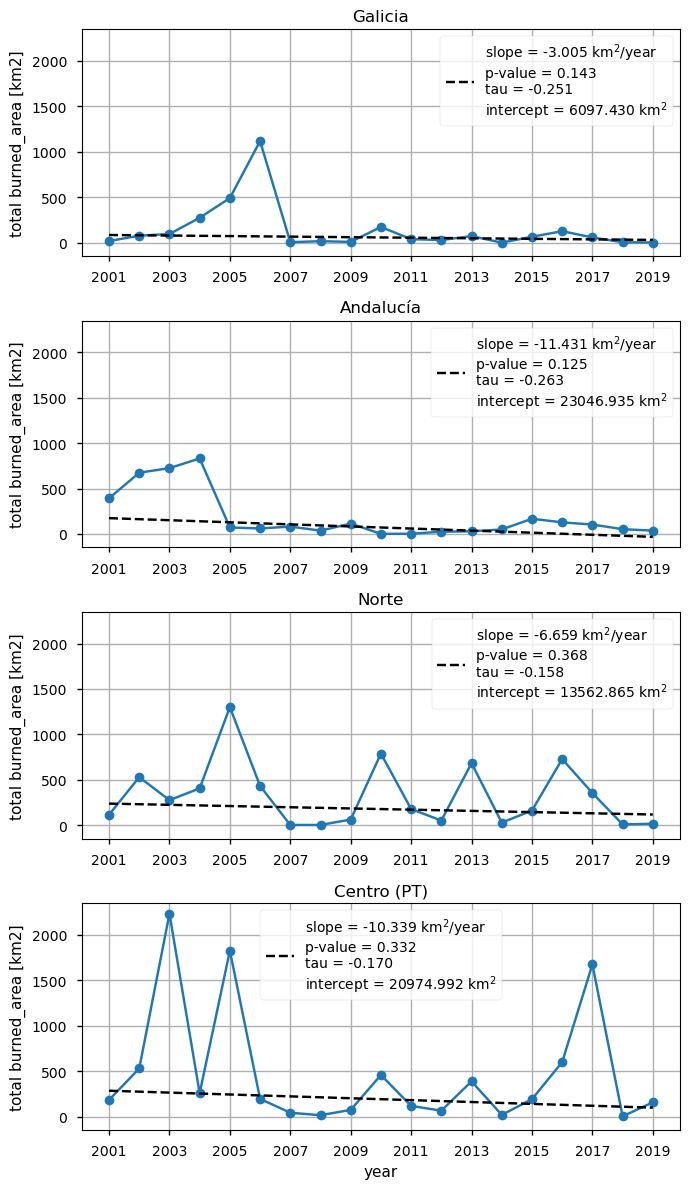

In [22]:
regions_of_interest = ["Galicia", "Andalucía", "Norte", "Centro (PT)"]
_ = plot_trend(da_grouped.sel(region=regions_of_interest), gdf, col_wrap=1, aspect=2)

The results show no significant trends, and a very high interannual variability. In general, these results largely agree with those of [[6]](https://doi.org/10.3390/FIRE4040074), although they used different periods, performed a global analysis and used a more sophisticated trend analysis scheme. They showed that the CCI datasets exhibit much less significant trends when compared to longer term datasets (such as those based in AVHRR observations), mainly due to the short time span of the timeseries.

(satellite_satellite-fire-burned-area_trend-assessment_q02:code-section-2.2)=
### 2.2. Yearly Trend Maps by NUTS regions.

Next, a regional view of these results is provided in map form, where the trends and their significance were calculated for each NUTS region.

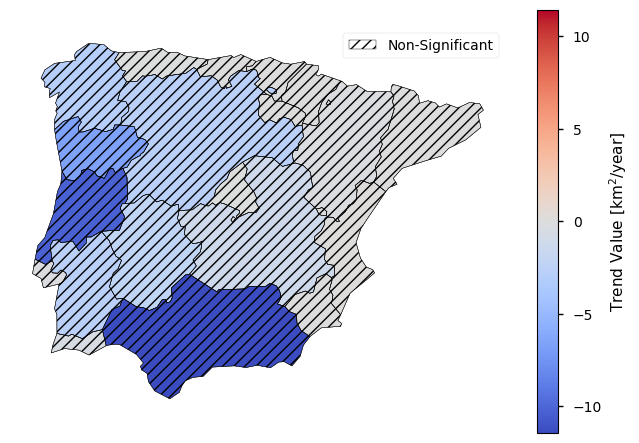

In [71]:
vmax = gdf["slope"].abs().max()
ax = gdf.plot(
    gdf["slope"],
    cmap="coolwarm",
    vmax=vmax,
    vmin=-vmax,
    edgecolor="k",
    legend=True,
    legend_kwds={"label": "Trend Value [km$^2$/year]"},
)
significant_gdf = gdf.loc[(gdf["p-value"] > 0.05)]
significant_gdf.plot(
    ax=ax,
    facecolor="none",
    hatch="///",
    edgecolor="k",
    label='Non-Significant'
)

# Create a proxy artist for the legend handle
legend_handles = [Patch(facecolor="white", edgecolor="black", hatch="///", label='Non-Significant')]

# Turn off the axis
_ = ax.axis("off")

# Show the legend with the proxy artist
ax.legend(handles=legend_handles, loc='upper right')

plt.show()

Regarding this map, it can be stated that the same conclusions apply to all NUTS regions over the Iberian Peninsula, as none of them exhibits significant burned area trends over the considered period, likely because the trends may not be robust due to the short time span of the time series. As discussed in sections 3.2.1 and 3.2.2 of [[6]](https://doi.org/10.3390/FIRE4040074), longer time series are crucial for detecting significant trends in burned area, as shorter periods are often subject to greater variability and noise. 

This aligns with findings from [[5]](https://doi.org/10.1088/2515-7620/AB25D2), which highlight that satellite datasets with limited temporal coverage can lead to inconsistencies and non-significant trends due to year-to-year fluctuations and sensor changes. Therefore, to obtain reliable and significant trends, it is recommended to utilize longer datasets that span several decades.

(satellite_satellite-fire-burned-area_trend-assessment_q02:code-section-3)=
### 3. Main takeaways

- The trend analysis across the studied NUTS 2 regions (Galicia, Andalucía, Norte, and Centro) for the summer months (June, July, August) from 2001 to 2019 revealed no significant trends in the burned area. This lack of significance suggests that the observed variations in burned area are largely due to interannual variability rather than a consistent temporal trend.

- The results align with findings from previous studies (e.g., [[6]](https://doi.org/10.3390/FIRE4040074)) that emphasize the importance of longer time series for trend detection. The short 18-year span of the dataset used in this analysis, particularly focused on the summer months, likely contributes to the absence of significant trends. Longer datasets would reduce the influence of year-to-year variability and provide more robust trend analysis.

- The absence of significant trends in the Iberian Peninsula's burned area is consistent with other research, such as [[8]](https://doi.org/10.1038/s41598-019-50281-2), which also found non-significant changes in burned areas in Portugal over a similar period (1980-2017). This reinforces the notion that short-term datasets are insufficient for capturing long-term trends in fire activity.

- Despite the lack of significant trends, the analysis demonstrates the reliability of the satellite-based dataset in capturing regional variations in burned area, particularly during significant fire events (e.g., the 2003 fires in Portugal). However, the non-significant trends suggest that more comprehensive datasets with broader temporal coverage are necessary for definitive conclusions.

- To achieve a more accurate and significant understanding of trends in burned areas, future studies should utilize longer datasets that span several decades. This would help mitigate the impact of short-term fluctuations and provide a clearer picture of fire activity trends over time.

## ℹ️ If you want to know more

### Key resources

Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entry for the data used were:

* Fire burned area from 2001 to present derived from satellite observations:

  https://cds.climate.copernicus.eu/datasets/satellite-fire-burned-area?tab=overview

EEA FIRE Climatology Methodology:
* https://www.eea.europa.eu/publications/europes-changing-climate-hazards-1

FIRE dataset Product User Guide (PUG):
* https://dast.copernicus-climate.eu/documents/satellite-fire-burned-area/D3.3.14-v1.0_PUGS_CDR_BA-FireCCI_MODIS_v5.1cds_PRODUCTS_v1.0.1.pdf 

Eurostat NUTS (Nomenclature of territorial units for statistics) regions and definition link:
* https://ec.europa.eu/eurostat/web/nuts

Code library used
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [B-Open](https://www.bopen.eu/)

### References

[[1]](https://doi.org/10.1007/s00704-023-04427-y) Bento, Virgílio A., Ana Russo, Inês Vieira, and Célia M. Gouveia. 2023. “Identification of Forest Vulnerability to Droughts in the Iberian Peninsula.” Theoretical and Applied Climatology 152 (1–2): 559–79. 

[[2]](https://doi.org/10.4000/MEDITERRANEE.9958) Lourenço, and Luciano. 2018. “Forest Fires in Continental PortugalResult of Profound Alterations in Society and Territorial Consequences”. no. 130 (September). 

[[3]](https://doi.org/10.1111/GCB.16547) Grünig, Marc, Rupert Seidl, and Cornelius Senf. 2023. “Increasing Aridity Causes Larger and More Severe Forest Fires across Europe.” Global Change Biology 29 (6): 1648–59. 

[[4]](https://doi.org/10.26682/csjuod.2020.23.2.41) Aswad, Fawaz & Yousif, Ali & Ibrahim, Sayran. (2020). "Trend Analysis Using Mann-Kendall and Sen’s Slope Estimator Test for Annual and Monthly Rainfall for Sinjar District, Iraq." 

[[5]](https://doi.org/10.1088/2515-7620/AB25D2) Forkel, Matthias, Wouter Dorigo, Gitta Lasslop, Emilio Chuvieco, Stijn Hantson, Angelika Heil, Irene Teubner, Kirsten Thonicke, and Sandy P. Harrison. 2019. “Recent Global and Regional Trends in Burned Area and Their Compensating Environmental Controls.” Environmental Research Communications 1 (5): 051005.

[[6]](https://doi.org/10.3390/FIRE4040074) Otón, Gonzalo, José Miguel C. Pereira, João M.N. Silva, and Emilio Chuvieco. 2021. “Analysis of Trends in the FireCCI Global Long Term Burned Area Product (1982–2018).” Fire 2021, Vol. 4, Page 74 4 (4): 74.

[[7]](https://doi.org/10.1007/s10668-020-00842-7) Rasul, Azad, Gaylan R.Faqe Ibrahim, Hasan M. Hameed, and Kevin Tansey. 2021. “A Trend of Increasing Burned Areas in Iraq from 2001 to 2019.” Environment, Development and Sustainability 23 (4): 5739–55.

[[8]](https://doi.org/10.1038/s41598-019-50281-2) Turco, M., Jerez, S., Augusto, S. et al. Climate drivers of the 2017 devastating fires in Portugal. Sci Rep 9, 13886 (2019). 

[[9]](https://climate.esa.int/en/projects/fire/key-documents/) Stroppiana D., Sali M., Boschetti M., Busetto L., Ranghetti L., Franquesa M., Lizundia-Loiola J., Pettinari M.L. (2022) ESA CCI ECV Fire Disturbance: D4.1 Product Validation and Intercomparison Report, version 2.1. Available at: https://climate.esa.int/en/projects/fire/key-documents/

[[10]](https://doi.org/10.3390/cli12090143) DaCamara, C.C. The Signature of Climate in Annual Burned Area in Portugal. Climate 2024, 12, 143. https://doi.org/10.3390/cli12090143